In [56]:
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv("Fields_lessColumns.csv")

df = df.loc[df['locality'] == 'Brasov']

test = df.sample(frac=0.25)
train = df.drop(test.index)

test.to_csv("Fields_test_Brasov_loc.csv")
train.to_csv("Fields_train_Brasov_loc.csv")


In [57]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *


In [58]:
paths = ["Fields_train_Brasov_loc.csv", "Fields_test_Brasov_loc.csv"]
target_name = "price"

In [60]:
rd = Reader(sep = ',')
df = rd.train_test_split(paths, target_name)


reading csv : Fields_train_Brasov_loc.csv ...
cleaning data ...
CPU time: 0.08596229553222656 seconds

reading csv : Fields_test_Brasov_loc.csv ...
cleaning data ...
CPU time: 0.042749881744384766 seconds

> Number of common features : 9

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 5
> Number of numerical features: 2
> Number of training samples : 637
> Number of test samples : 212

> Top sparse features (% missing values on train set):
noFronturi            49.0
frontStradal          40.2
contructionOnLand     33.4
landType              32.0
landClassification    12.4
dtype: float64

> Task : regression
count    6.370000e+02
mean     3.473104e+05
std      6.716496e+05
min      0.000000e+00
25%      5.000000e+04
50%      1.240000e+05
75%      3.360000e+05
max      5.801400e+06
Name: price, dtype: float64


In [61]:
df["test"].head()

,_id,contructionOnLand,frontStradal,landArea,landClassification,landType,noFronturi
0,hefj,NaN,NaN,1000.0,NaN,NaN,NaN
1,50613JQ5BEK,Nu,80.0,10000.0,intravilan,constructii,1.0
2,4MI03IJJUIH,Nu,58.0,10000.0,intravilan,constructii,NaN
3,i6yP,NaN,NaN,2400.0,NaN,NaN,NaN
4,6O403GH9CQH,Nu,22.0,4411.0,intravilan,constructii,NaN


In [62]:
df["train"].head()

,_id,contructionOnLand,frontStradal,landArea,landClassification,landType,noFronturi
0,02A130013OB,Nu,28.0,590,intravilan,constructii,1.0
1,09I03CVI8RO,Nu,37.0,1160,intravilan,constructii,1.0
2,09I03GOUAAU,Nu,19.0,905,intravilan,constructii,1.0
3,09I03H6JOBQ,Nu,25.0,1018,intravilan,constructii,1.0
4,09I03IETC6O,Nu,40.0,9800,intravilan,constructii,1.0


In [63]:
dft = Drift_thresholder()
df = dft.fit_transform(df)


computing drifts ...
CPU time: 0.19757580757141113 seconds

> Top 10 drifts

('landArea', 0.9984276729559749)
('_id', 0.9968652037617556)
('frontStradal', 0.07361939883483926)
('landClassification', 0.052409211993246)
('noFronturi', 0.038499785917261775)
('landType', 0.01927842027398885)
('contructionOnLand', 0.005452367427730032)

> Deleted variables : ['_id', 'landArea']
> Drift coefficients dumped into directory : save


In [64]:
# opt = Optimiser(n_folds = 3)
# opt.evaluate(None, df)

In [65]:
opt = Optimiser(n_folds = 4)
space_xgb={
'ne__numerical_strategy'    :{"search":"choice",
                              "space":[0,'mean','median','most_frequent']},
'ne__categorical_strategy'  :{"search":"choice",
                              "space":["<NULL>"]},
'ce__strategy'              :{"search":"choice",
                              "space":['entity_embedding']},
'fs__strategy'              :{"search":"choice",
                              "space":['l1','variance','rf_feature_importance']},
'fs__threshold'             :{"search":"uniform",
                              "space":[0.01,0.6]},
'est__max_depth'            :{"search":"choice",
                              "space":[3,4,5,6,7]},
'est__learning_rate'        :{"search":"uniform",
                              "space":[0.01,0.1]},
'est__subsample'            :{"search":"uniform",
                              "space":[0.4,0.9]},
'est__reg_alpha'            :{"search":"uniform",
                              "space":[0,10]},
'est__reg_lambda'           :{"search":"uniform",
                              "space":[0,10]},
'est__n_estimators'         :{"search":"choice",
                              "space":[1000,1250,1500]}
}

best = opt.optimise(space_xgb, df, 60)

##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'entity_embedding'}
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.06950583703974685}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'learning_rate': 0.06936717186707661, 'max_depth': 4, 'n_estimators': 1000, 'reg_alpha': 8.315865194346726, 'reg_lambda': 7.807583154740623, 'subsample': 0.8917906305248549, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
  0%|          | 0/60 [00:00<?, ?trial/s, best loss=?]

/home/alex/Documents/ngnt/matching/MLBox/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")


MEAN SCORE : neg_mean_squared_error = -457125174760.0323
VARIANCE : 198742832416.5306 (fold 1 = -234724577601.61346, fold 2 = -597237820122.2667, fold 3 = -705048769135.8054, fold 4 = -291489532180.44366)
CPU time: 5.541123867034912 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'entity_embedding'}
>>> FEATURE SELECTOR :{'strategy': 'variance', 'threshold': 0.4111211296847981}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'learning_rate': 0.0971683928145958, 'max_depth': 6, 'n_estimators': 1000, 'reg_alpha': 2.507218196507358, 'reg_lambda': 4.128747385482905, 'subsample': 0.8071467305012132, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves


fitting the pipeline ...
CPU time: 1.3517239093780518 seconds


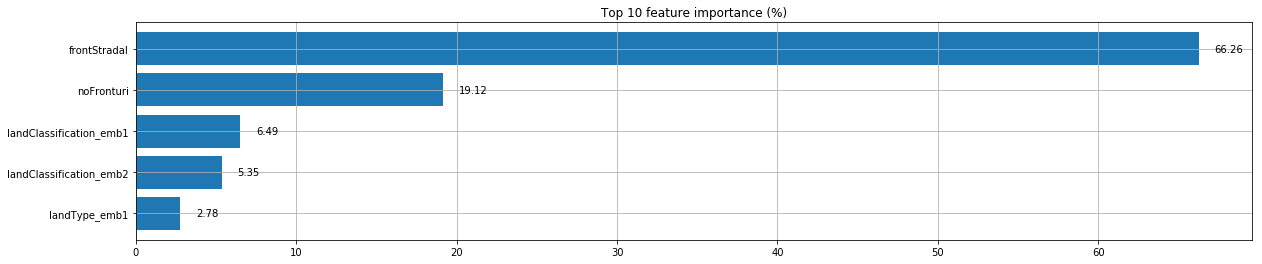


> Feature importances dumped into directory : save

predicting...
USING MY WAYYY
CPU time: 0.06922721862792969 seconds

> Overview on predictions : 

   price_predicted
0     1.949976e+05
1     7.157559e+05
2     4.628800e+05
3     1.949976e+05
4     1.098864e+05
5     1.108313e+06
6     7.973107e+04
7     2.196866e+05
8     1.949976e+05
9     1.068250e+06

dumping predictions into directory : save ...


In [66]:
from mlbox.prediction import *
prd = Predictor()
prd.fit_predict(best, df)

13159800.0


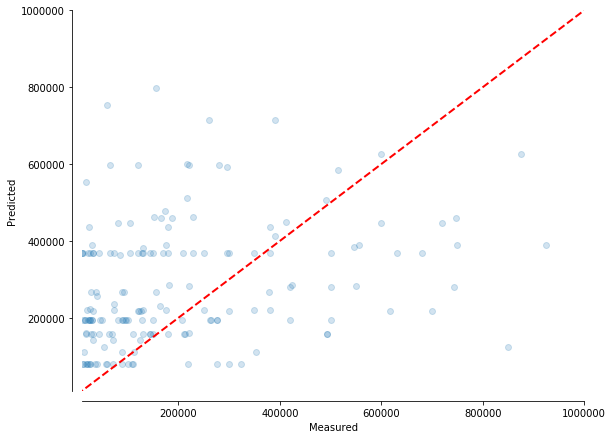

In [69]:
import matplotlib.pyplot as plt

def plot_regression_results(ax, y_true, y_pred):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)
    
    ax.set_xlim([10000, 1000000])
    ax.set_ylim([10000, 1000000])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
#     ax.set_xlim([y_true.min(), y_true.max()])
#     ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

    plt.show()
    
pred = pd.read_csv("save/price_predictions.csv")
true = pd.read_csv("Fields_test_Brasov_loc.csv")

y_pred = pred["price_predicted"]
y_true = true[true.columns[2]]

fig, axs = plt.subplots(1, 1, figsize=(9, 7))
axs = np.ravel(axs)

print(max(y_true.values))

plot_regression_results(axs[0], y_true, y_pred)